In [21]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.


In [22]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image

### Creating SQL Database Connection and Converting tables to dfs ###

In [23]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [24]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)


### Some Graphs

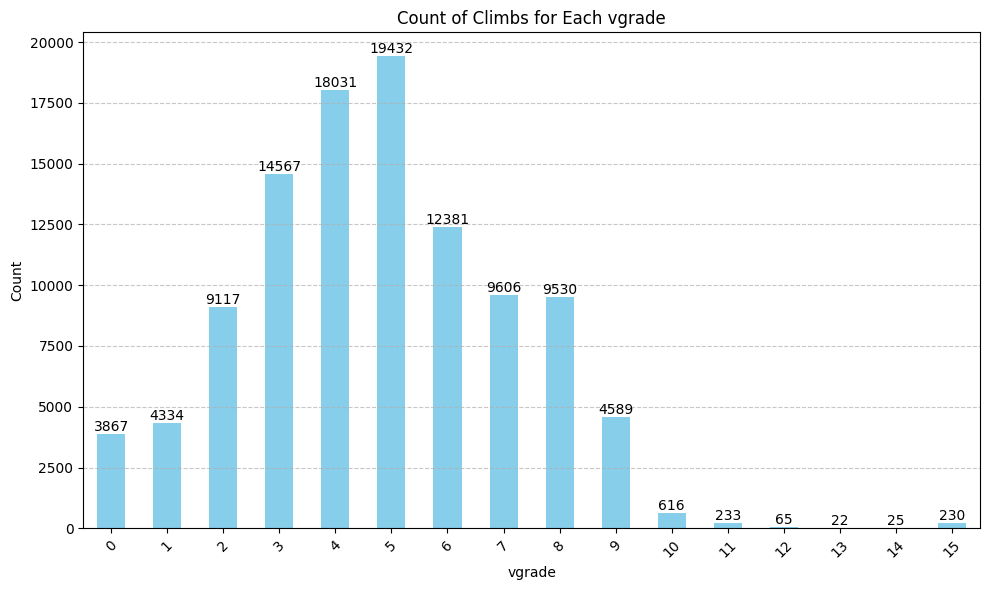

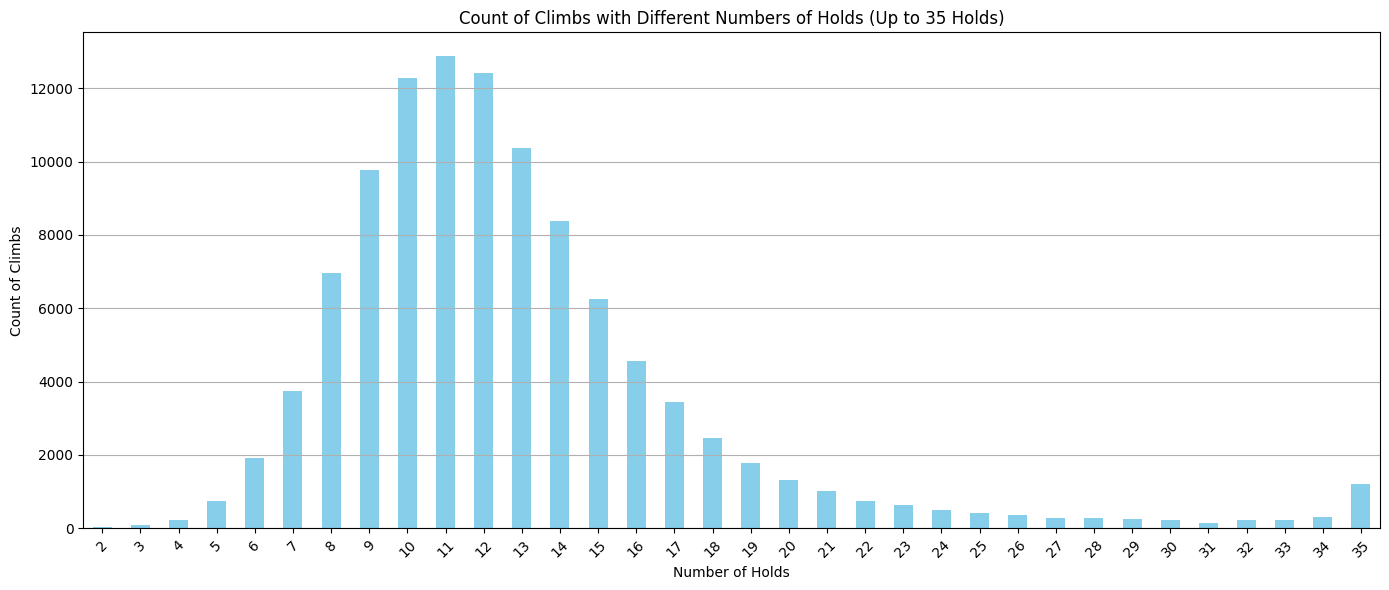

Average Number of Holds: 12.844174994364716
4704
4721
4689
4692
4704
4696
4699
4812
4743
4752
4794
4844
4681
4686
4691
4695
4699
4705
4709
4712
4718
4721
4735
4805
4808
4811
4814
4742
4755
4758
4788
4702
4753
4756
4797
4784
4827
4828
4684
4688
4718
4684
4718
4723
4729
4775
4781
4796
4800
4818
4717
4737
4773
4794
4749
4753
4783
4784
4789
4798
4826
4685
4686
4722
4726
4690
4691
4695
4707
4725
4737
4741
4743
4759
4760
4799
4690
4707
4714
4723
4737
4695
4810
4707
4709
4714
4723
4687
4795
4771
4773
4839
4756
4712
4696
4698
4737
4746
4760
4780
4782
4704
4710
4726
4731
4732
4735
4740
4744
4748
4780
4695
4697
4729
4737
4760
4763
4771
4780
4781
4695
4729
4697
4723
4725
4726
4729
4745
4838
4740
4744
4767
4827
4687
4801
4692
4715
4725
4731
4802
4805
4746
4770
4771
4794
4830
4833
4836
4745
4748
4767
4824
4688
4707
4835
4690
4801
4803
4707
4806
4782
4827
4834
4835
4744
4747
4827
4830
4833
4704
4705
4720
4709
4712
4721
4750
4771
4786
4794
4825
4745
4762
4787
4712
4737
4808
4721
4722
4741
4746
4749
4

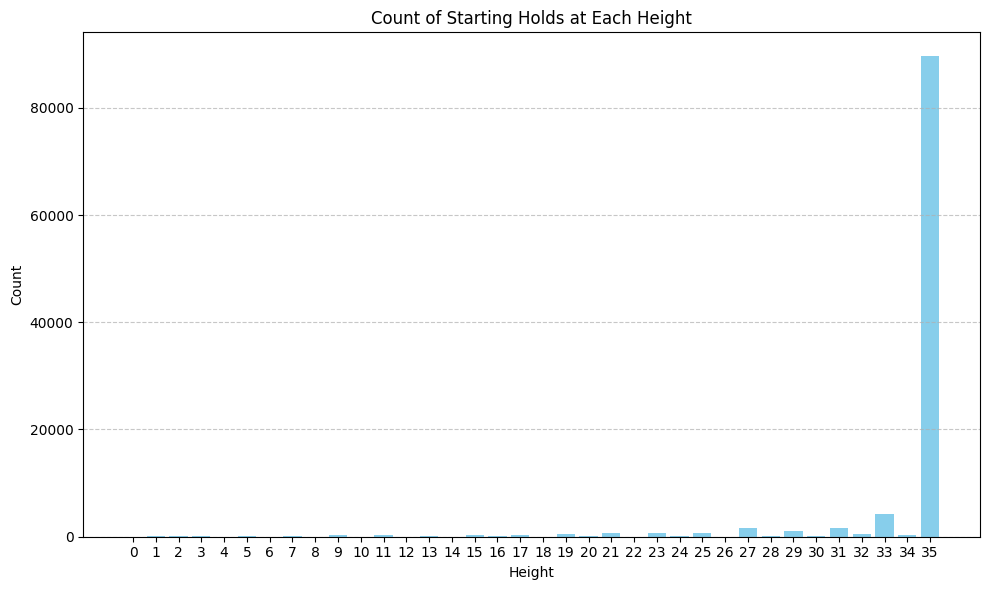

Overall Average Starting Hold Height: 33.84063768060067
Percentage of climbs with starting holds at height 35: 96.74225245653817
Number of Unique Climbs: 106645


In [25]:
plot_vgrade_counts(filtered_df)
plot_hold_counts(filtered_df)
average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
print_unique_climbs_count(filtered_df)


### Create Text File

In [26]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'
word_counts = count_unique_words(file_path)

if word_counts:
    sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
    for word, count in sorted_word_counts:
        print(word, count)


Number of Unique Words: 1861
Sum of All Word Counts: 1340776
1599r15 56
1599r14 30
1599r13 15
1598r15 153
1598r14 49
1598r13 78
1597r15 72
1597r14 54
1597r13 314
1596r15 125
1596r14 45
1596r13 228
1596r12 1
1595r15 144
1595r14 46
1595r13 197
1595r12 2
1594r15 91
1594r14 36
1594r13 322
1593r15 110
1593r14 43
1593r13 179
1593r12 1
1592r15 64
1592r14 31
1592r13 58
1591r15 46
1591r14 50
1591r13 16
1590r15 206
1590r14 16
1590r13 24
1590r12 1
1589r15 199
1589r14 8
1589r13 45
1589r12 1
1588r15 271
1588r14 5
1588r13 113
1587r15 213
1587r14 8
1587r13 195
1587r12 1
1586r15 301
1586r14 13
1586r13 171
1586r12 1
1585r15 246
1585r14 11
1585r13 154
1585r12 1
1584r15 195
1584r14 12
1584r13 106
1583r15 269
1583r14 11
1583r13 76
1582r15 92
1582r14 10
1582r13 29
1581r15 247
1581r14 4
1581r13 21
1580r15 475
1580r14 12
1580r13 190
1579r15 417
1579r14 7
1579r13 154
1578r15 485
1578r14 17
1578r13 725
1578r12 1
1577r15 429
1577r14 12
1577r13 410
1577r12 4
1576r15 377
1576r14 4
1576r13 389
1576r12 1
1575r15 47

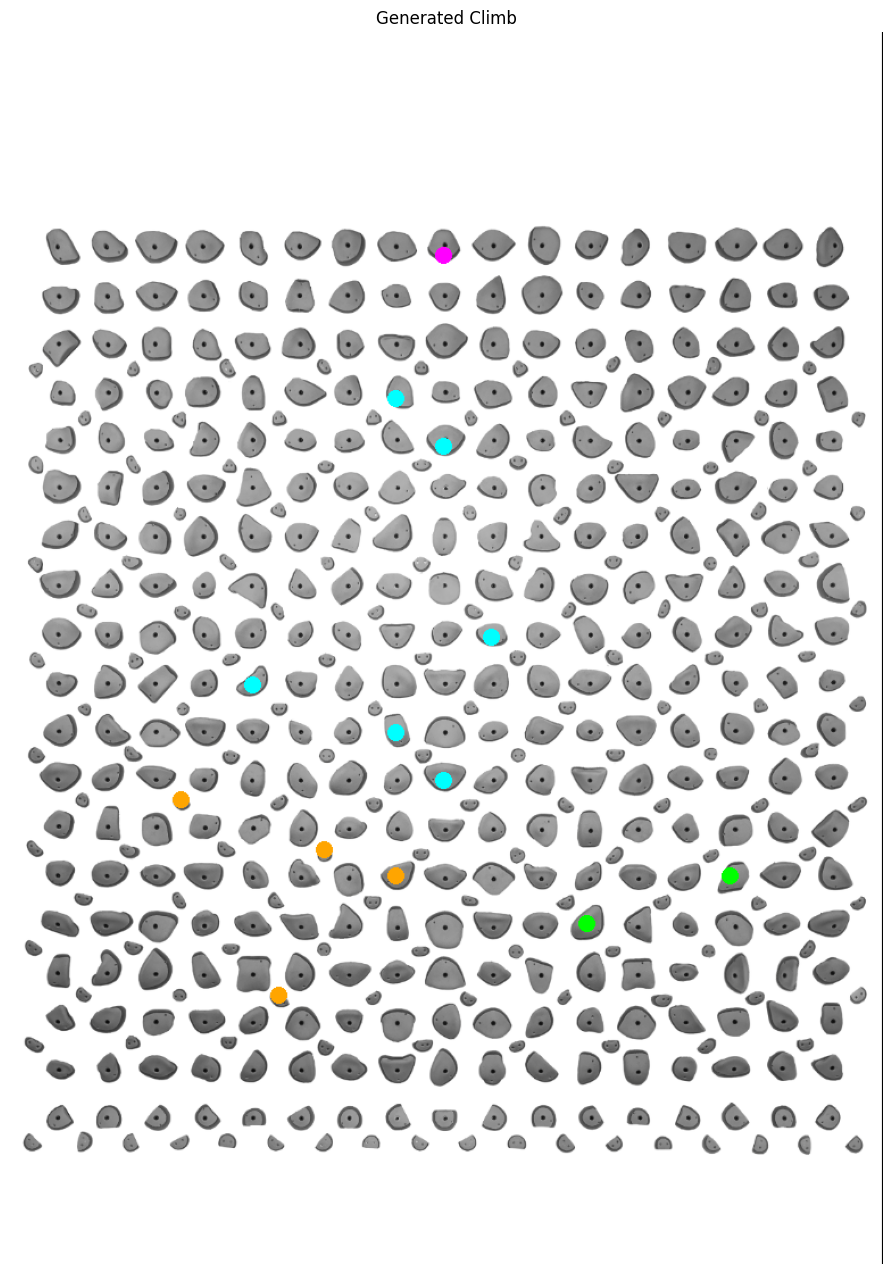

In [27]:
frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
frame_to_image(frame)

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1163r12 1216r13 1228r13 1270r15 1271r13 1272r13 1332r13 1335r13 1338r13 1391r14 1469r15 1471r15


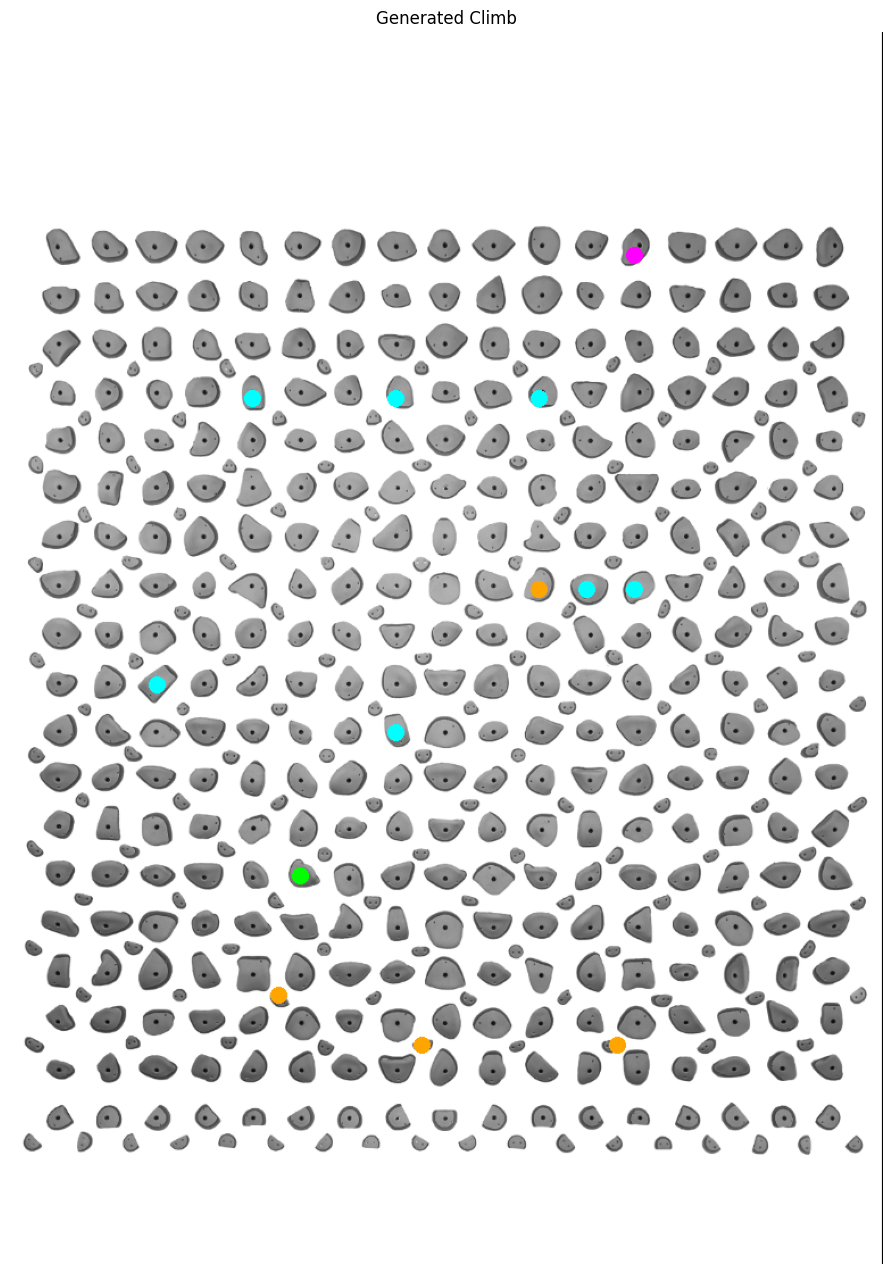

In [28]:
from collections import defaultdict
import string
import random

class Markov():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text = self.remove_punctuations(self.get_text())
        self.model = self.model()

    def get_text(self):
        text = []
        for line in open(self.file_path):
            text.append(line)
        return ' '.join(text)
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('','', string.punctuation))
    
    def model(self):
        # split the input text into individual words seperated by spaces
        words = self.text.split(' ')
        markov_dict = defaultdict(list)
        # create list of all word pairs
        for current_word, next_word in zip(words[0:-1], words[1:]):
            markov_dict[current_word].append(next_word)
        markov_dict = dict(markov_dict)
        print('Successfully Trained')
        return markov_dict
    
def predict_words(chain, first_word, number_of_words):
    if first_word in list(chain.keys()):
        word1 = str(first_word)
        predictions = word1.capitalize()
        # Generate the second word from the value list. Set the new word as the first word. Repeat.
        for i in range(number_of_words):
            word2 = random.choice(chain[word1])
            word1 = word2
            predictions += ' ' + word2
        # # End it with a period
        # predictions += '.'
        return predictions
    else:
        return "Word not in corpus"
    
def is_valid_sequence(sequence):
    # Count the number of start holds (r12) and finish holds (r14)
    start_hold_count = sequence.count('r12')
    finish_hold_count = sequence.count('r14')

    # Check if the counts are within the specified range
    return 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2

def predict_valid_sequence(chain, start_hold, number_of_words):
    while True:
        # Generate a sequence of words using the Markov chain model
        sequence = predict_words(chain, start_hold, number_of_words)
        
        # Convert the sequence to a string
        sequence_str = ' '.join(sequence.split())
        # Check if the sequence is valid
        if is_valid_sequence(sequence_str):
            return sequence_str

if __name__ == '__main__':
    m = Markov(file_path='climbs.txt')
    chain = m.model
    start_hold = '1476r15'  # Example start hold
    
    # Predict a valid sequence
    valid_sequence = predict_valid_sequence(chain, start_hold, number_of_words=13)
    print("Valid Sequence:", valid_sequence)
    generated_frame = 'p' + valid_sequence.replace(' ', 'p')
    frame_to_image(generated_frame)
# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [9]:
import embeddings as emb

def hold_distance(hold_1_id, hold_2_id, coo_matrix):
    #given hold id in sparse matrix representation return distance
    x1, y1 = sparse_matrix.col[hold_1_id], sparse_matrix.row[hold_1_id]
    x2, y2 = sparse_matrix.col[hold_2_id], sparse_matrix.row[hold_2_id]
    
    # Calculate Euclidean distance between the two holds
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

hold_directions = emb.hold_directions
hold_directions2 = emb.hold_directions2
hold_magnitudes = emb.hold_magnitudes

# def get_hold_vector(hold_id, coo_matrix):# get hold embedding
#     x = coo_matrix.col[hold_id]
#     y = coo_matrix.row[hold_id]
#     # data = coo_matrix.data[hold_id] # if its a foot maybe do something different?
#     if max(hold_directions[34-y][x]) > 1:
#         index = hold_directions[34-y][x][0]-1
#         hold_vector = hold_directions2[index] *hold_magnitudes[34-y][x]
#         # print(f"hold coord: {x}, {y} | hold dir: {hold_directions2[34-y][x]} | hold mag: {hold_magnitudes[34-y][x]}")
#     else:
#         # print(f"hold coord: {x}, {y} | hold dir: {hold_directions[34-y][x]} | hold mag: {hold_magnitudes[34-y][x]}")
#         hold_vector = hold_directions[34-y][x] * hold_magnitudes[34-y][x]
#     # print("\n")
#     return np.array(hold_vector)

def get_hold_vector(hold_id, coo_matrix):# get hold embedding
    x = coo_matrix.col[hold_id]
    y = coo_matrix.row[hold_id]
    # data = coo_matrix.data[hold_id] # if its a foot maybe do something different?
    if max(hold_directions[34-y][x]) > 1:
        index = hold_directions[34-y][x][0]-1
        # print(f"hold coord: {x}, {y} | hold dir: {hold_directions2[34-y][x]} | hold mag: {hold_magnitudes[34-y][x]}")
        return hold_directions2[index], hold_magnitudes[34-y][x]
    else:
        # print(f"hold coord: {x}, {y} | hold dir: {hold_directions[34-y][x]} | hold mag: {hold_magnitudes[34-y][x]}")
        return hold_directions[34-y][x], hold_magnitudes[34-y][x]


# converts coo_matrix into a feature matrix where each row is a different hold containing
# holds row, col, type(2-5), sin(angle), cos(angle), hold_quality
def create_hold_matrix(coo_matrix):
    num_holds = len(coo_matrix.row)
    feature_matrix = np.zeros((num_holds, 6)) 

    for i in range(num_holds):
        row = coo_matrix.row[i]
        col = coo_matrix.col[i]
        hold_type = coo_matrix.data[i]

        hold_vector, hold_quality = get_hold_vector(i, coo_matrix)

        sin_angle = np.sin(hold_vector[0])
        cos_angle = np.cos(hold_vector[0])

        feature_matrix[i] = [row, col, hold_type, sin_angle, cos_angle, hold_quality]

    feature_matrix = feature_matrix[feature_matrix[:, 0].argsort()]
    return feature_matrix

def square_loss(pred_coo_matrix, target_coo_matrix):
    pred_rows, pred_cols, pred_data = pred_coo_matrix.row, pred_coo_matrix.col, pred_coo_matrix.data
    target_rows, target_cols, target_data = target_coo_matrix.row, target_coo_matrix.col, target_coo_matrix.data

    last_index = len(pred_data) - 1

    pred_hold = [pred_rows[last_index], pred_cols[last_index], pred_data[last_index]]
    target_hold = [target_rows[last_index], target_cols[last_index], target_data[last_index]]

    squared_loss = 0.0
    for i in range(3):
        squared_loss += (pred_hold[i] - target_hold[i]) ** 2
    
    return squared_loss


# def find_closest_hold(hand_1_id, hand_2_id, coo_matrix):
#     # TODO
#     return closest_hold_id, farthest_hand_id #The farthest_hand_id is either the current hand 1 or 2. This is the hand that will move to the closest_hold_id



ModuleNotFoundError: No module named 'embeddings'

### Plotting Functions

p1476r15p1534r15p1300r12p1301r12p1302r14


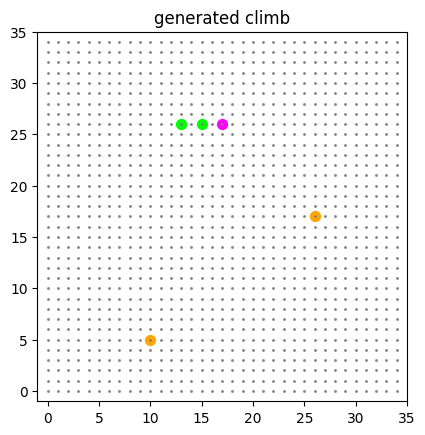

COO representation of the sparse matrix:
Column: [10 26 13 15 17]
Row: [ 5 17 26 26 26]
Data: [5 5 2 2 4]
F_loss1: 1
S_loss: 1
[0.13  0.152]
[-0.114  0.164]
[0.063 0.7  ]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def print_sparse_matrix(sparse_matrix):
    print("COO representation of the sparse matrix:")
    print("Column:", sparse_matrix.col)
    print("Row:", sparse_matrix.row)
    print("Data:", sparse_matrix.data)
    
# Define a function to plot a sparse matrix with different hold types as different colors
def plot_climb(sparse_matrix, title):
    hold_colors = {2: '#00FF00', 3: '#00FFFF', 4: '#FF00FF', 5: 'orange'}

    x = sparse_matrix.col
    y = sparse_matrix.row
    z = sparse_matrix.data

    plt.xlim(-1, 35)
    plt.ylim(-1, 35)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # since its a sparse matrix, we can just plot the elements that are there
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=hold_colors[z[i]], s=50)
    
    # we are plotting the smaller grey dots after over on top of the colored ones
    for i in range(35):
        for j in range(35):
            plt.scatter(i, j, color='grey', s=1)
    plt.title(title)
    plt.show()

# def plot_climb_with_name(title):
#     #todo

def plot_random_climb():
    random_sample = filtered_df.sample()
    frame = random_sample['frames'].values[0]
    print(frame)
    sparse_matrix = frame_to_sparse_matrix(frame)
    plot_climb(sparse_matrix, f"{random_sample['name'].values[0]} (v{random_sample['vgrade'].values[0]})")

def plot_generated_climb(start_hold,number_of_holds):
    generated_climb_frame = "p" + predict_valid_sequence(chain, start_hold, number_of_holds).replace(" ", "p")[0:-1]
    if generated_climb_frame[-1]=="p":
        generated_climb_frame = generated_climb_frame[0:-1]
    print(generated_climb_frame)
    sparse_matrix = frame_to_sparse_matrix(generated_climb_frame)
    plot_climb(sparse_matrix, "generated climb")
    print_sparse_matrix(sparse_matrix)
    # print(f"F_loss2: {F_loss2(sparse_matrix)}")
    sum = np.array([0.0, 0.0])
    for i in range(len(sparse_matrix.data)):
        
        print(get_hold_vector(i, sparse_matrix))
        sum += get_hold_vector(i, sparse_matrix)
    print(sum)

plot_generated_climb('1476r15', 5)
plot_random_climb()



### Open Pandas gui for database

In [ ]:
# show(filtered_df)